In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy.special import digamma, gamma
from npeet import entropy_estimators as ee
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
print(os.getcwd())
os.chdir('..')
from load_data import read_Decoding_csv, load_neural_npz
from load_stimulus_data import build_drift_grating_stim, build_static_grating_stim, build_nature_scenes_grating_stim, build_nature_movie_grating_stim, stimulus_mat2vec, get_contained_names,create_stimulus_mat
os.chdir('..')
print(os.getcwd())

d:\生科课\计算与系统神经科学\SCNSProject\src\forwardNetworkModels
d:\生科课\计算与系统神经科学\SCNSProject


e:\miniconda\conda\envs\SCNS\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [ ]:
def TSNE_DBSCAN(VISal_A_selected_spikes,title='')->tuple[np.ndarray,np.ndarray]:
    eps = 0.2
    k=3
    np.random.seed(42)
    tsne = TSNE(n_components=2, random_state=42)
    scaler = StandardScaler()
    scaler.fit(VISal_A_selected_spikes)
    # scaler.fit(scaler.transform(VISal_A_selected_spikes))
    VISal_spikes_transformed = tsne.fit_transform(scaler.transform(VISal_A_selected_spikes))
    dbscan_model = DBSCAN(eps=eps,min_samples=k+1)
    label = dbscan_model.fit_predict(VISal_spikes_transformed)
    print(np.unique(label))
    print(VISal_spikes_transformed.shape)
    plt.scatter(VISal_spikes_transformed[:, 0], VISal_spikes_transformed[:, 1],c=label)
    plt.xlabel('TSNE1')
    plt.ylabel('TSNE2')
    plt.legend()
    plt.title(title)
    plt.show()
    return label, VISal_spikes_transformed

def show_label_neuron_image(label, all_roi_masks_sessions,title='',color_bar_label='')->None:
    corresponding_imgs = all_roi_masks_sessions[0]
    avg_mask = np.zeros_like(corresponding_imgs[0,:,:],dtype=np.int16)
    for i in range(len(label)):
        curr_mask = np.where(corresponding_imgs[i,:,:]>0,1,0) * np.int16(label[i]+2)
        avg_mask = np.where(curr_mask>avg_mask,curr_mask,avg_mask)
    plt.figure(figsize=(8, 6))
    c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))
    plt.imshow(avg_mask, cmap=c_map)
    plt.colorbar(label='Cluster' if not color_bar_label else color_bar_label)
    plt.title(title)
    plt.show()

def compute_mutual_info(stimulus_sequence, neuron_activity, n_bins=4, mode='separate'):
    """
    计算神经元活动与刺激序列之间的互信息
    
    参数:
    - stimulus_sequence: shape (ts,) 的整数序列，值域为 1~N_stimulus
    - neuron_activity: shape (n_neuron, ts) 的神经元活动矩阵
    - n_bins: 离散化的bin数，默认3
    - mode: 'separate' 或 'joint'
        - 'separate': 每个神经元单独计算互信息
        - 'joint': 将所有神经元拼接后作为联合状态计算一次互信息

    返回:
    - MI值（单独模式为list，整体模式为float）
    """

    stimulus_sequence = np.array(stimulus_sequence)
    neuron_activity = np.array(neuron_activity)

    if mode == 'separate':
        mi_list = []
        for i in range(neuron_activity.shape[0]):
            neuron = neuron_activity[i,:]
            # 使用KBinsDiscretizer进行分箱
            discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile',quantile_method='averaged_inverted_cdf')
            neuron_discrete = discretizer.fit_transform(neuron.reshape(-1, 1)).astype(int).flatten()

            mi = mutual_info_score(stimulus_sequence, neuron_discrete)
            mi_list.append(mi)
            # print(f'Neuron {i}: MI = {mi:.4f}')
        return mi_list

    elif mode == 'joint':
        # 所有神经元活动堆叠，形成 shape = (ts, n_neuron)
        activity_T = neuron_activity.T
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
        activity_discrete = discretizer.fit_transform(activity_T).astype(int)

        # 将多维离散状态编码为单个整数
        base = n_bins
        joint_state = np.zeros(activity_discrete.shape[0], dtype=int)
        for i in range(activity_discrete.shape[1]):
            joint_state = ( joint_state + activity_discrete[:, i] * (base ** i)).astype(int)

        mi = mutual_info_score(stimulus_sequence, joint_state)
        # print(f'Joint MI (all neurons): {mi:.4f}')
        return mi

    else:
        raise ValueError("mode 参数必须为 'separate' 或 'joint'")

    
def compute_population_mi(X_continuous, Y_discrete):
    mi_per_neuron = mutual_info_classif(X_continuous, Y_discrete, discrete_features=False, n_neighbors=5)
    avg_mi = np.mean(mi_per_neuron)
    return mi_per_neuron, avg_mi

# %%
def analyze_session(dff, selected_vec, roi_masks, brain_region, session):
    X = dff.T  # (n_timepoints, n_neurons)
    y = selected_vec


    mi_per_neuron, population_mi = compute_population_mi(X, y)
    print(f"[{brain_region}-{session}] Population MI: {population_mi:.4f}")

    plt.hist(mi_per_neuron, bins=20)
    plt.title(f'Continuous-Discrete Mutual Information\n{brain_region}-({session})')
    plt.vlines(x=np.mean(mi_per_neuron), ymin=0, ymax=plt.gca().get_ylim()[1], color='red')
    plt.legend([f'Mean: {np.mean(mi_per_neuron):.5f}'])
    plt.xlabel('Mutual Information Value $I(Neuron; Stimulus)$')
    plt.ylabel('Count')
    plt.show()
    labels = mi_per_neuron*100
    # labels = np.zeros_like(mi_values)
    # labels = np.where(mi_values >  0.05, 5, labels)
    # labels = np.where(mi_values >  0.15, 15, labels)
    # labels = np.where(mi_values >  0.25, 25, labels)
    # labels = np.where(mi_values >  0.35, 35, labels)
    # labels += 5
    show_label_neuron_image(labels, roi_masks, f"[{brain_region}-{session}] Population MI: {population_mi:.4f}", 'Mutual Information/%')
    #show_label_neuron_image(mi_values, roi_masks,title='',color_bar_label='')
    return {
        'brain_region': brain_region,
        'session': session,
        'population_mi': population_mi
    }


# load data
def create_session_data(Target_Brain_region = 'VISal', data_root='data', session_letter='B'):
    # Target_Brain_region = 'VISal'
    # data_root = 'data'
    sessions = [session_letter]
    session_datas = []
    session_folders = [] 
    for session in sessions:
        tgt_dict, tgt_folder = read_Decoding_csv(data_path=data_root,region_type = Target_Brain_region, session_letter = session)
        session_datas.append(tgt_dict)
        session_folders.append(tgt_folder)
    print('================================================')
    print(session_folders)

    ts_sessions = []
    dff_sessions = []
    all_roi_masks_sessions = []
    cids_sessions = []
    metadata_sessions = []
    spike_info_sessions = []
    information_dicts = {}


    for tgt_data_path in session_folders:
        for file_name in os.listdir(os.path.join(data_root, tgt_data_path)):
            if file_name.endswith('.npz'):
                ts, dff, all_roi_masks, cids, metadata = load_neural_npz(os.path.join(data_root, tgt_data_path,file_name))
                ts_sessions.append(ts)
                dff_sessions.append(dff)
                all_roi_masks_sessions.append(all_roi_masks)
                cids_sessions.append(cids)
                metadata_sessions.append(metadata)
                spike_info_sessions = [dff]
                # spike_info_sessions.append(np.array([deconvolve(dff[_i,:], penalty=1)[1] for _i in trange(dff.shape[0])]))
                position = metadata.tolist()
                print('================================================')
                print('Caution, the position of this file is about the brain part of', position['targeted_structure'])
                print('================================================')
            elif file_name.endswith('.csv') and file_name.find('Decoding') == -1:
                information_dicts[file_name.split('.')[0]] = pd.read_csv(os.path.join(data_root, tgt_data_path,file_name))  
    print('================================================')
    if 'stimulus_metadata_natural_movie_one' in information_dicts.keys() and 'stimulus_metadata_natural_movie_three' in information_dicts.keys():
        information_dicts['stimulus_metadata_natural_movie'] = pd.concat([information_dicts['stimulus_metadata_natural_movie_one'],information_dicts['stimulus_metadata_natural_movie_three']])
        information_dicts.pop('stimulus_metadata_natural_movie_one')
        information_dicts.pop('stimulus_metadata_natural_movie_three')
    print(information_dicts.keys())
    return ts_sessions,  dff_sessions, all_roi_masks_sessions , cids_sessions, metadata_sessions, spike_info_sessions, information_dicts

def get_indices_of_segments_every_20_percent(arr):
    # Step 1: 找到分段的起始和结束位置
    is_diff = np.diff(arr, prepend=arr[0] - 1) != 0
    segment_starts = np.where(is_diff)[0]
    segment_ends = np.concatenate([segment_starts[1:], [len(arr)]])
    
    result_indices = []

    for start, end in zip(segment_starts, segment_ends):
        length = end - start
        if length == 0:
            continue
        # Step 2: 在该段内选 5 个点：0%, 20%, 40%, 60%, 80%
        selected_positions = np.linspace(0, length - 1, num=6, dtype=int)
        selected_indices = start + selected_positions
        result_indices.extend(selected_indices)

    return np.array(result_indices)



we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three-al.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_total.csv
['VISal_three_session_A_501876401']
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
Caution, the position of this file is about the brain part of VISal
dict_keys(['stimulus_metadata_drifting_gratings', 'stimulus_metadata_natural_movie_one', 'stimulus_metadata_natural_movie_three-al', 'stimulus_metadata_spontaneous', 'stimulus_metadata_total'])
dict_keys(['drifting_gratings', 'natural_movie', 'spontaneous'])
timelength =  115492


599it [00:00, 24351.92it/s]


Drift grating stimulus_mat.shape =  (41, 115492)
(41, 115492)
VISal_A_selected_spikes.shape (181, 36604)
[VISal-A] Population MI: 0.0194


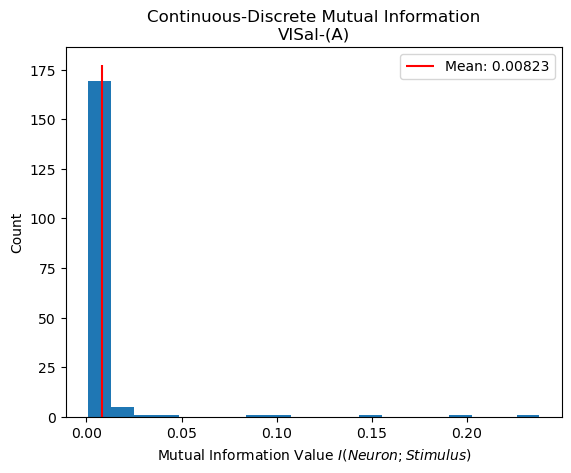

C:\Users\10690\AppData\Local\Temp\ipykernel_18292\1472456915.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


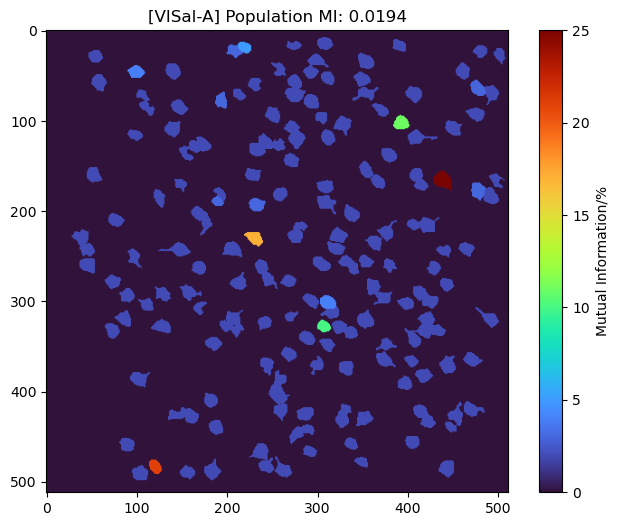

{'brain_region': 'VISal',
 'session': 'A',
 'avg_neuron_mi': 0.00823355276452552,
 'population_mi': 0.01939832392276411}

In [4]:
Target_Brain_region = 'VISal'
data_root = 'data'
session_letter = 'A'
VISal_A_ts_sessions,  VISal_A_dff_sessions, VISal_A_all_roi_masks_sessions , VISal_A_cids_sessions, VISal_A_metadata_sessions, VISal_A_spike_info_sessions, VISal_A_information_dicts = create_session_data(Target_Brain_region = Target_Brain_region, data_root=data_root, session_letter=session_letter)
VISal_A_contained_names, VISal_A_contained_keys = get_contained_names(VISal_A_information_dicts)
VISal_A_total_stimulus = create_stimulus_mat(VISal_A_contained_names,ts=VISal_A_ts_sessions[0])
VISal_A_stimulus_vec = stimulus_mat2vec(VISal_A_total_stimulus)
VISal_A_selected_ts = np.where(VISal_A_stimulus_vec!=0)[0]
VISal_A_selected_vec = VISal_A_stimulus_vec[VISal_A_selected_ts]
VISal_A_selected_spikes = VISal_A_spike_info_sessions[0][:,VISal_A_selected_ts]
print('VISal_A_selected_spikes.shape',VISal_A_selected_spikes.shape)
# VISal_A_cdmis = continuous_discrete_MI(VISal_A_selected_spikes.T,VISal_A_selected_vec)
# # [continuous_discrete_MI(VISal_A_selected_spikes[_i,:],VISal_A_selected_vec) for _i in trange(VISal_A_selected_spikes.shape[0])]
# plt.hist(VISal_A_cdmis, bins=50)
# plt.title(f'Continuous-Discrete Mutual Information {Target_Brain_region}-(Session {session_letter})')
# plt.vlines(x=np.mean(VISal_A_cdmis),ymin=0,ymax=np.max(plt.gca().get_ylim()),color='red')
# plt.legend(['Mean: {:.2f}'.format(np.mean(VISal_A_cdmis))])
# plt.xlabel('Mutual Information Value $I(Neuron;Stimulus)$')
# plt.ylabel('Count')
# plt.show()
# mi = ee.mi(VISal_A_selected_spikes.T, VISal_A_selected_vec)
# print(mi)
# print(compute_mutual_info(VISal_A_selected_vec,VISal_A_selected_spikes))
analyze_session(VISal_A_selected_spikes, VISal_A_selected_vec, VISal_A_all_roi_masks_sessions, Target_Brain_region, session_letter)

Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "e:\miniconda\conda\envs\SCNS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "e:\miniconda\conda\envs\SCNS\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "e:\miniconda\conda\envs\SCNS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "e:\miniconda\conda\envs\SCNS\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "e:\miniconda\conda\envs\SCNS\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xce in position 4: invalid continuation byte


[-1  0  1  2  3]
(181, 2)


C:\Users\10690\AppData\Local\Temp\ipykernel_18292\1472456915.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


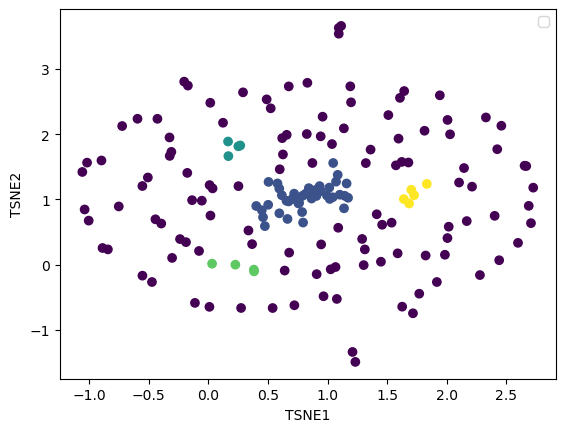

C:\Users\10690\AppData\Local\Temp\ipykernel_18292\1472456915.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


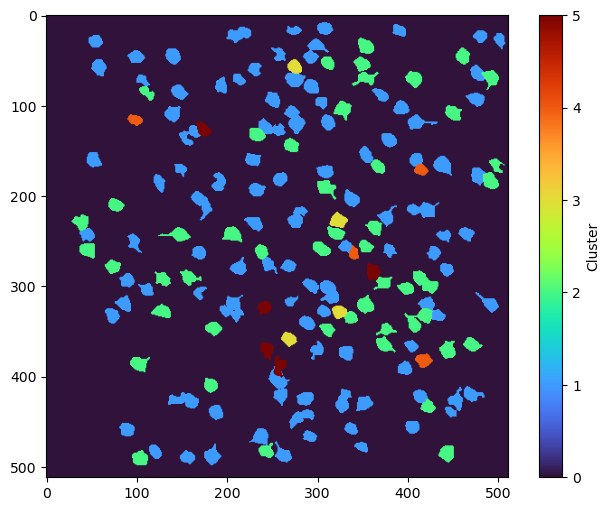

In [5]:
label, VISal_spikes_transformed = TSNE_DBSCAN(VISal_A_selected_spikes)
show_label_neuron_image(label,VISal_A_all_roi_masks_sessions)

we have keys in data_dict, including:
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_scenes.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_static_gratings.csv
stimulus_metadata_total.csv
['VISal_three_session_B_501929146']
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
Caution, the position of this file is about the brain part of VISal
dict_keys(['stimulus_metadata_natural_movie_one', 'stimulus_metadata_natural_scenes', 'stimulus_metadata_spontaneous', 'stimulus_metadata_static_gratings', 'stimulus_metadata_total'])
dict_keys(['static_gratings', 'natural_scenes', 'natural_movie', 'spontaneous'])
timelength =  113852


5805it [00:00, 25398.36it/s]


Static grating stimulus_mat.shape =  (121, 113852)
(121, 113852)
VISal_B_selected_spikes.shape (172, 41794)
[VISal-B] Population MI: 0.0118


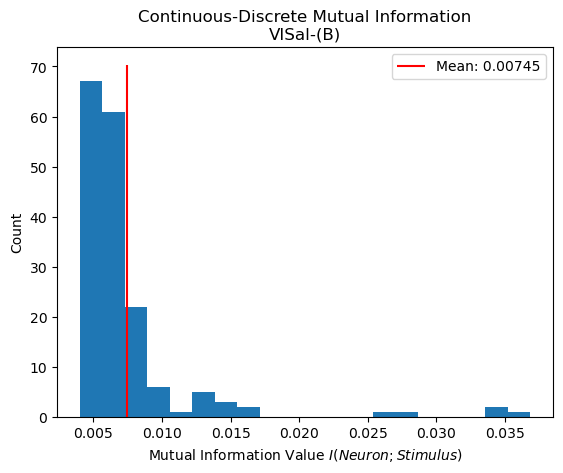

C:\Users\10690\AppData\Local\Temp\ipykernel_18292\1472456915.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


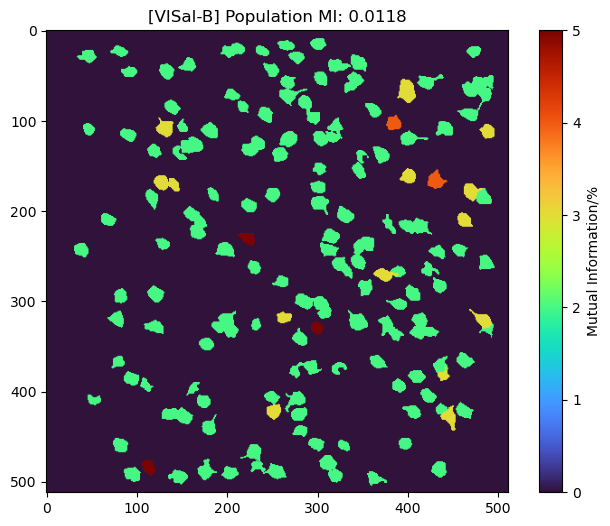

{'brain_region': 'VISal',
 'session': 'B',
 'avg_neuron_mi': 0.007451416822536036,
 'population_mi': 0.011834527672140233}

In [6]:
Target_Brain_region = 'VISal'
data_root = 'data'
session_letter = 'B'
VISal_B_ts_sessions,  VISal_B_dff_sessions, VISal_B_all_roi_masks_sessions , VISal_B_cids_sessions, VISal_B_metadata_sessions, VISal_B_spike_info_sessions, VISal_B_information_dicts = create_session_data(Target_Brain_region = Target_Brain_region, data_root=data_root, session_letter=session_letter)
VISal_B_contained_names, VISal_B_contained_keys = get_contained_names(VISal_B_information_dicts)
VISal_B_total_stimulus = create_stimulus_mat(VISal_B_contained_names,ts=VISal_B_ts_sessions[0])
VISal_B_stimulus_vec = stimulus_mat2vec(VISal_B_total_stimulus)
VISal_B_selected_ts = np.where(VISal_B_stimulus_vec!=0)[0]
VISal_B_selected_vec = VISal_B_stimulus_vec[VISal_B_selected_ts]
VISal_B_selected_spikes = VISal_B_spike_info_sessions[0][:,VISal_B_selected_ts]
print('VISal_B_selected_spikes.shape',VISal_B_selected_spikes.shape)
# VISal_B_cdmis = continuous_discrete_MI(VISal_B_selected_spikes.T,VISal_B_selected_vec)#[continuous_discrete_MI(VISal_B_selected_spikes[_i,:],VISal_B_selected_vec) for _i in trange(VISal_B_selected_spikes.shape[0])]
# plt.hist(VISal_B_cdmis, bins=20)
# plt.title(f'Continuous-Discrete Mutual Information {Target_Brain_region}-(Session {session_letter})')
# plt.vlines(x=np.mean(VISal_B_cdmis),ymin=0,ymax=np.max(plt.gca().get_ylim()),color='red')
# plt.legend(['Mean: {:.2f}'.format(np.mean(VISal_B_cdmis))])
# plt.xlabel('Mutual Information Value $I(Neuron;Stimulus)$')
# plt.ylabel('Count')
# plt.show()

analyze_session(VISal_B_selected_spikes, VISal_B_selected_vec, VISal_B_all_roi_masks_sessions, Target_Brain_region, session_letter)

we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_total.csv
['VISl_three_session_A_502793808']
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
Caution, the position of this file is about the brain part of VISl
dict_keys(['stimulus_metadata_drifting_gratings', 'stimulus_metadata_spontaneous', 'stimulus_metadata_total', 'stimulus_metadata_natural_movie'])
dict_keys(['drifting_gratings', 'natural_movie', 'spontaneous'])
timelength =  115469


598it [00:00, 23921.96it/s]


Drift grating stimulus_mat.shape =  (41, 115469)
(41, 115469)
selected_spikes.shape (153, 36590)
[VISl-A] Population MI: 0.0398


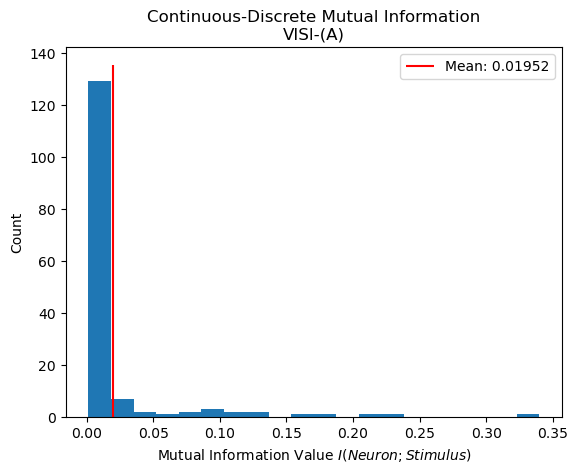

C:\Users\10690\AppData\Local\Temp\ipykernel_18292\1472456915.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


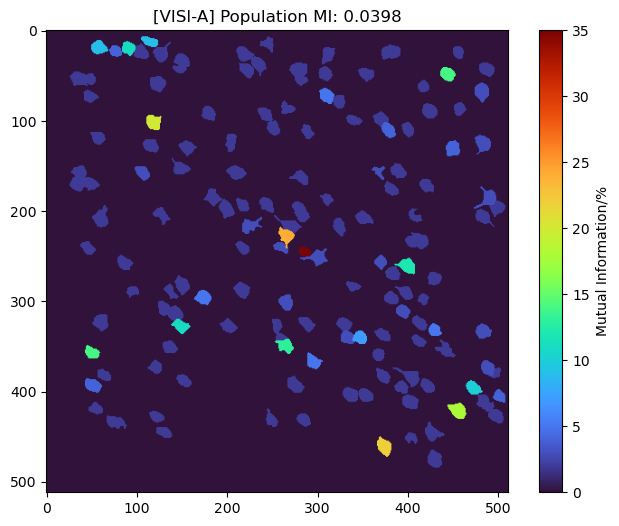

{'brain_region': 'VISl',
 'session': 'A',
 'avg_neuron_mi': 0.019516133063593333,
 'population_mi': 0.039847448246124136}

In [7]:
Target_Brain_region = 'VISl'
data_root = 'data'
session_letter = 'A'
VISl_A_ts_sessions,  VISl_A_dff_sessions, VISl_A_all_roi_masks_sessions , VISl_A_cids_sessions, VISl_A_metadata_sessions, VISl_A_spike_info_sessions, VISl_A_information_dicts = create_session_data(Target_Brain_region = Target_Brain_region, data_root=data_root, session_letter=session_letter)
VISl_A_contained_names, VISl_A_contained_keys = get_contained_names(VISl_A_information_dicts)
VISl_A_total_stimulus = create_stimulus_mat(VISl_A_contained_names,ts=VISl_A_ts_sessions[0])
VISl_A_stimulus_vec = stimulus_mat2vec(VISl_A_total_stimulus)
VISl_A_selected_ts = np.where(VISl_A_stimulus_vec!=0)[0]
VISl_A_selected_vec = VISl_A_stimulus_vec[VISl_A_selected_ts]
VISl_A_selected_spikes = VISl_A_spike_info_sessions[0][:,VISl_A_selected_ts]
print('selected_spikes.shape',VISl_A_selected_spikes.shape)
# VISl_A_cdmis = continuous_discrete_MI(VISl_A_selected_spikes.T,VISl_A_selected_vec)# [continuous_discrete_MI(VISl_A_selected_spikes[_i,:],VISl_A_selected_vec) for _i in trange(VISl_A_selected_spikes.shape[0])]
# plt.hist(VISl_A_cdmis, bins=20)
# plt.title(f'Continuous-Discrete Mutual Information {Target_Brain_region}-(Session {session_letter})')
# plt.vlines(x=np.mean(VISl_A_cdmis),ymin=0,ymax=np.max(plt.gca().get_ylim()),color='red')
# plt.legend(['Mean: {:.2f}'.format(np.mean(VISl_A_cdmis))])
# plt.xlabel('Mutual Information Value $I(Neuron;Stimulus)$')
# plt.ylabel('Count')
# plt.show()

analyze_session(VISl_A_selected_spikes, VISl_A_selected_vec, VISl_A_all_roi_masks_sessions, Target_Brain_region, session_letter)

we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_natural_scenes.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_static_gratings.csv
stimulus_metadata_total.csv
['VISl_three_session_B_502526200']
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
Caution, the position of this file is about the brain part of VISl
dict_keys(['stimulus_metadata_drifting_gratings', 'stimulus_metadata_natural_scenes', 'stimulus_metadata_spontaneous', 'stimulus_metadata_static_gratings', 'stimulus_metadata_total', 'stimulus_metadata_natural_movie'])
dict_keys(['drifting_gratings', 'static_gratings', 'natural_scenes', 'natural_movie', 'spontaneous'])
timelength =  113862


598it [00:00, 23920.59it/s]


Drift grating stimulus_mat.shape =  (41, 113862)
timelength =  113862


5806it [00:00, 25457.47it/s]


Static grating stimulus_mat.shape =  (121, 113862)
(162, 113862)
selected_spikes.shape (175, 52312)
[VISl-B] Population MI: 0.0180


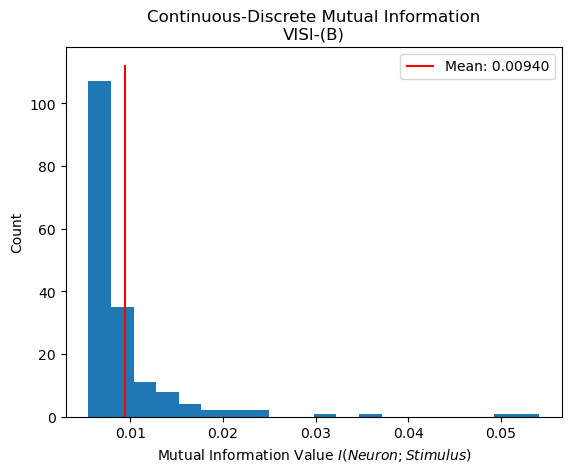

C:\Users\10690\AppData\Local\Temp\ipykernel_18292\1472456915.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


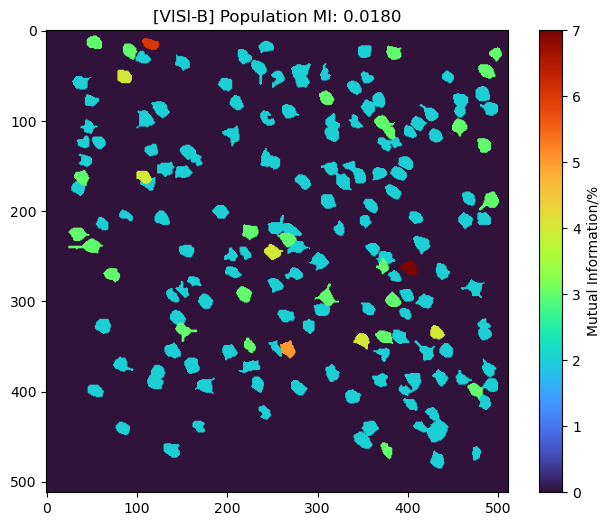

{'brain_region': 'VISl',
 'session': 'B',
 'avg_neuron_mi': 0.009401811346249851,
 'population_mi': 0.018007548091377775}

In [8]:
Target_Brain_region = 'VISl'
data_root = 'data'
session_letter = 'B'
VISl_B_ts_sessions,  VISl_B_dff_sessions, VISl_B_all_roi_masks_sessions , VISl_B_cids_sessions, VISl_B_metadata_sessions, VISl_B_spike_info_sessions, VISl_B_information_dicts = create_session_data(Target_Brain_region = Target_Brain_region, data_root=data_root, session_letter=session_letter)
VISl_B_contained_names, contained_keys = get_contained_names(VISl_B_information_dicts)
VISl_B_total_stimulus = create_stimulus_mat(VISl_B_contained_names,ts=VISl_B_ts_sessions[0])
VISl_B_stimulus_vec = stimulus_mat2vec(VISl_B_total_stimulus)
VISl_B_selected_ts = np.where(VISl_B_stimulus_vec!=0)[0]
VISl_B_selected_vec = VISl_B_stimulus_vec[VISl_B_selected_ts]
VISl_B_selected_spikes = VISl_B_spike_info_sessions[0][:,VISl_B_selected_ts]
print('selected_spikes.shape',VISl_B_selected_spikes.shape)
# VISl_B_cdmis = continuous_discrete_MI(VISl_B_selected_spikes.T,VISl_B_selected_vec)# [continuous_discrete_MI(VISl_B_selected_spikes[_i,:],VISl_B_selected_vec) for _i in trange(VISl_B_selected_spikes.shape[0])]
# plt.hist(VISl_B_cdmis, bins=20)
# plt.title(f'Continuous-Discrete Mutual Information {Target_Brain_region}-(Session {session_letter})')
# plt.vlines(x=np.mean(VISl_B_cdmis),ymin=0,ymax=np.max(plt.gca().get_ylim()),color='red')
# plt.legend(['Mean: {:.2f}'.format(np.mean(VISl_B_cdmis))])
# plt.xlabel('Mutual Information Value $I(Neuron;Stimulus)$')
# plt.ylabel('Count')
# plt.show()

analyze_session(VISl_B_selected_spikes, VISl_B_selected_vec, VISl_B_all_roi_masks_sessions, Target_Brain_region, session_letter)

we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_spontaneous.csv
['VISp_three_session_A_501704220']
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
Caution, the position of this file is about the brain part of VISp
dict_keys(['stimulus_metadata_drifting_gratings', 'stimulus_metadata_spontaneous', 'stimulus_metadata_natural_movie'])
dict_keys(['drifting_gratings', 'natural_movie', 'spontaneous'])
timelength =  115514


598it [00:00, 23916.26it/s]


Drift grating stimulus_mat.shape =  (41, 115514)
(41, 115514)
selected_spikes.shape (142, 36598)
[VISp-A] Population MI: 0.0150


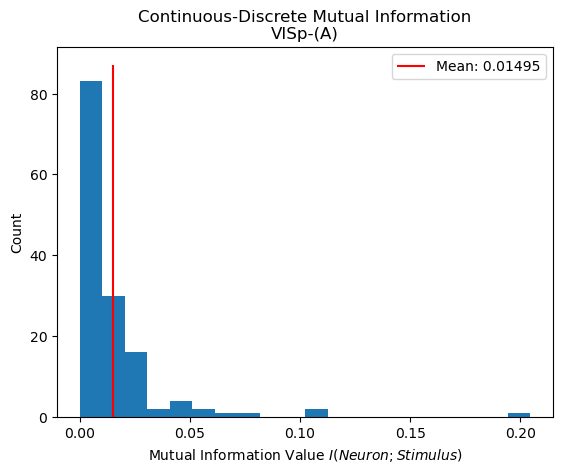

C:\Users\10690\AppData\Local\Temp\ipykernel_8464\353198015.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


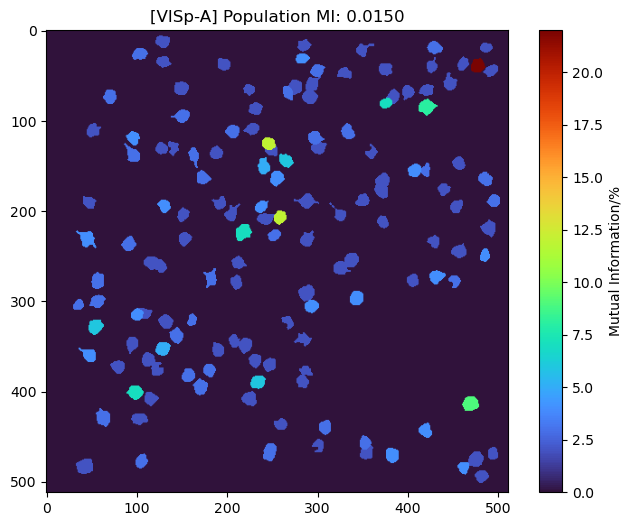

{'brain_region': 'VISp', 'session': 'A', 'population_mi': 0.014950153549241625}

In [31]:
Target_Brain_region = 'VISp'
data_root = 'data'
session_letter = 'A'

VISp_A_ts_sessions,  VISp_A_dff_sessions, VISp_A_all_roi_masks_sessions , VISp_A_cids_sessions, VISp_A_metadata_sessions, VISp_A_spike_info_sessions, VISp_A_information_dicts = create_session_data(Target_Brain_region = Target_Brain_region, data_root=data_root, session_letter=session_letter)
VISp_A_contained_names, contained_keys = get_contained_names(VISp_A_information_dicts)
VISp_A_total_stimulus = create_stimulus_mat(VISp_A_contained_names,ts=VISp_A_ts_sessions[0])
VISp_A_stimulus_vec = stimulus_mat2vec(VISp_A_total_stimulus)
VISp_A_selected_ts = np.where(VISp_A_stimulus_vec!=0)[0]
VISp_A_selected_vec = VISp_A_stimulus_vec[VISp_A_selected_ts]
VISp_A_selected_spikes = VISp_A_spike_info_sessions[0][:,VISp_A_selected_ts]
print('selected_spikes.shape',VISp_A_selected_spikes.shape)
# VISp_A_cdmis = continuous_discrete_MI(VISp_A_selected_spikes.T,VISp_A_selected_vec)# [continuous_discrete_MI(VISp_A_selected_spikes[_i,:],VISp_A_selected_vec) for _i in trange(VISp_A_selected_spikes.shape[0])]
# plt.hist(VISp_A_cdmis, bins=20)
# plt.title(f'Continuous-Discrete Mutual Information {Target_Brain_region}-(Session {session_letter})')
# plt.vlines(x=np.mean(VISp_A_cdmis),ymin=0,ymax=np.max(plt.gca().get_ylim()),color='red')
# plt.legend(['Mean: {:.2f}'.format(np.mean(VISp_A_cdmis))])
# plt.xlabel('Mutual Information Value $I(Neuron;Stimulus)$')
# plt.ylabel('Count')
# plt.show()

analyze_session(VISp_A_selected_spikes, VISp_A_selected_vec, VISp_A_all_roi_masks_sessions, Target_Brain_region, session_letter)

[VISp-A First 20] Population MI: 0.0189


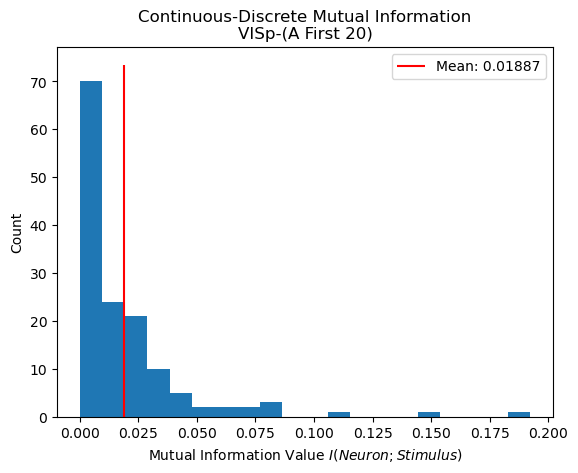

C:\Users\10690\AppData\Local\Temp\ipykernel_8464\353198015.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


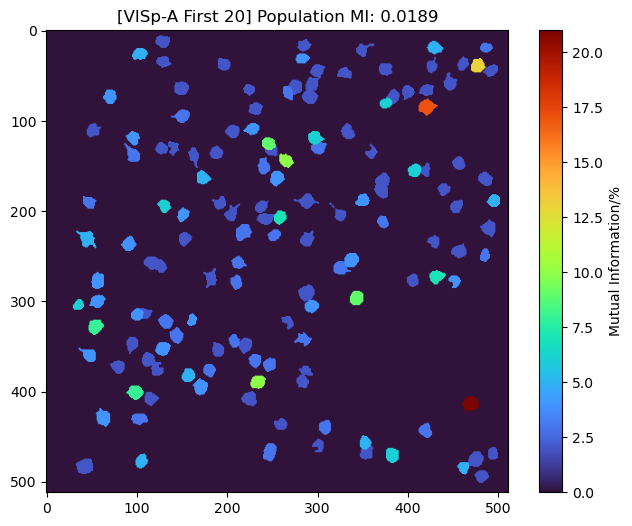

[VISp-A Second 20] Population MI: 0.0246


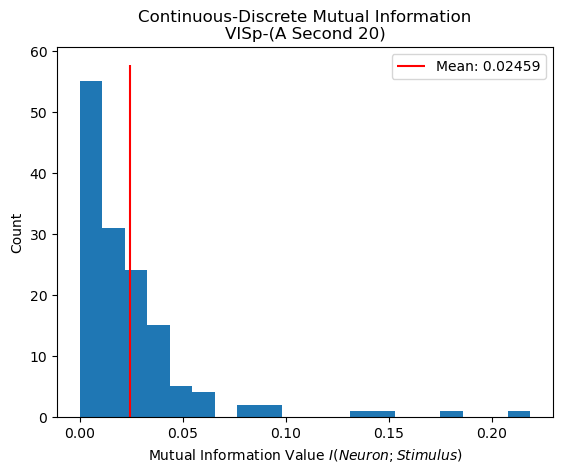

C:\Users\10690\AppData\Local\Temp\ipykernel_8464\353198015.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


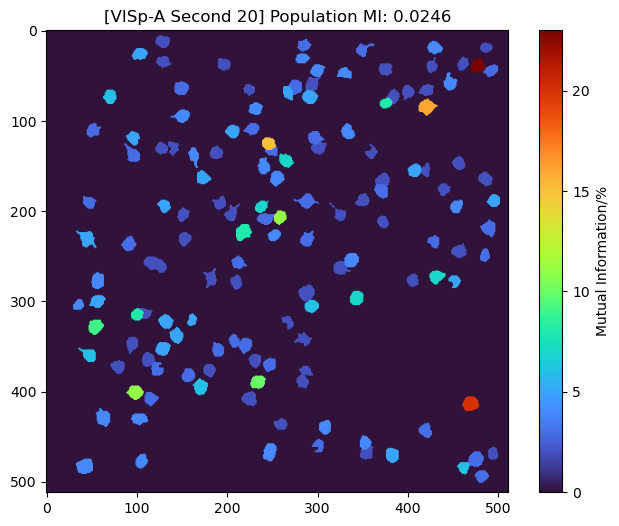

[VISp-A Third 20] Population MI: 0.0222


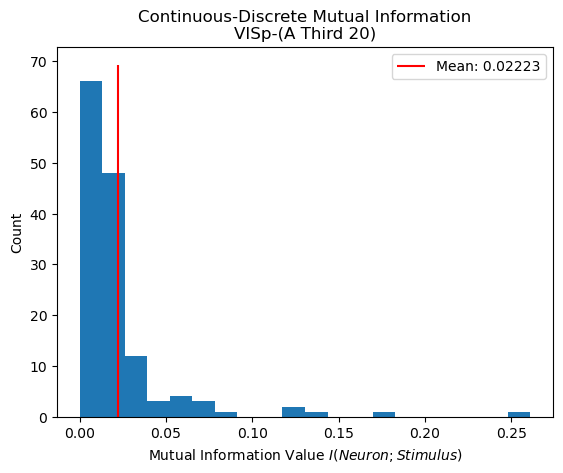

C:\Users\10690\AppData\Local\Temp\ipykernel_8464\353198015.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


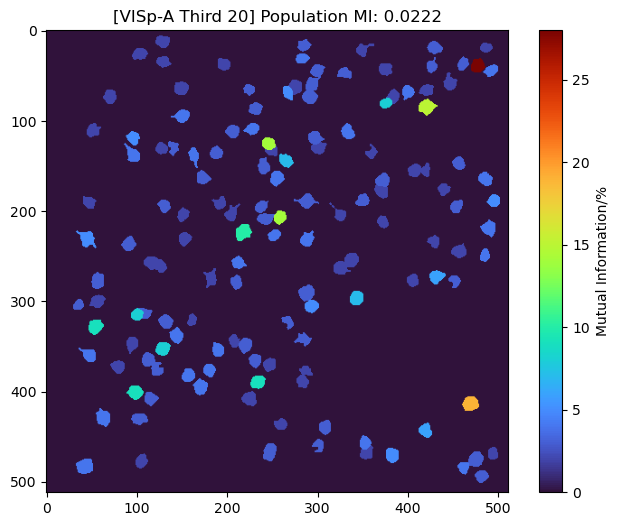

[VISp-A Forth 20] Population MI: 0.0214


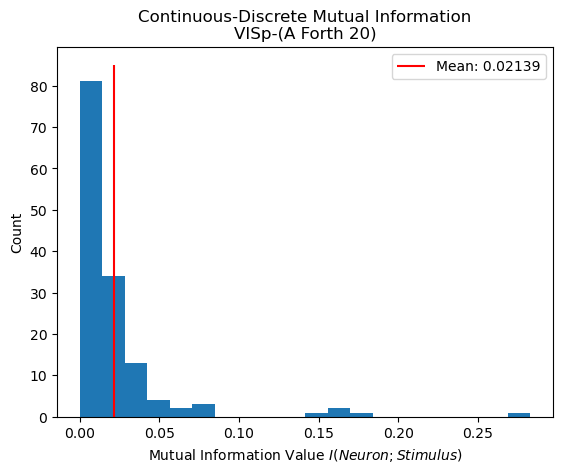

C:\Users\10690\AppData\Local\Temp\ipykernel_8464\353198015.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


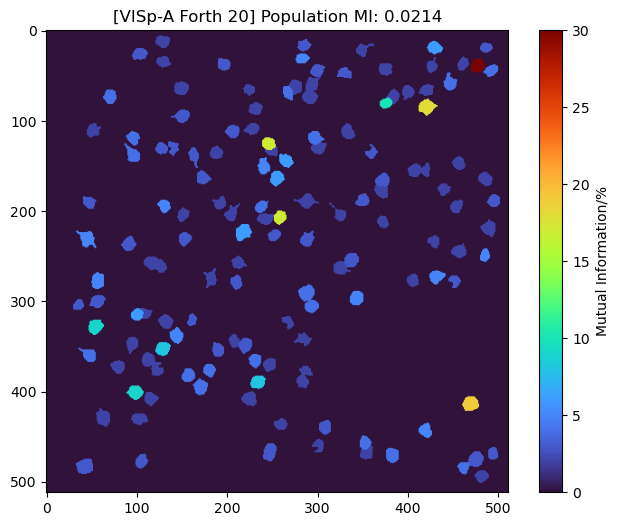

[VISp-A Fifth 20] Population MI: 0.0243


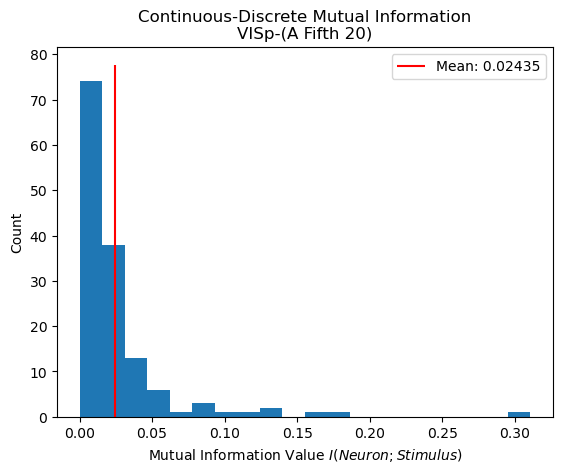

C:\Users\10690\AppData\Local\Temp\ipykernel_8464\353198015.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


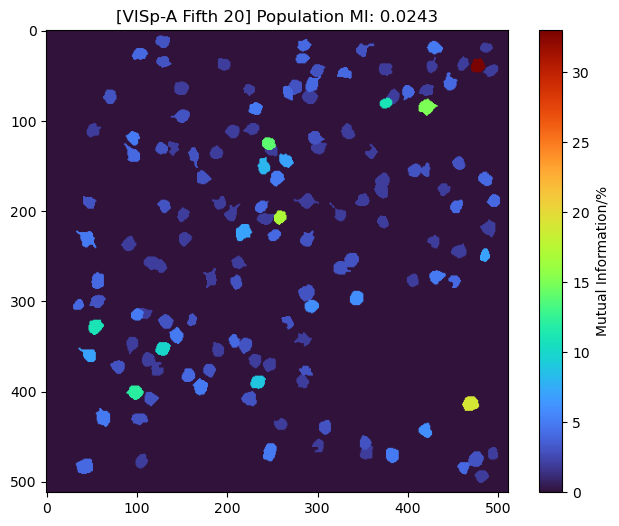

{'brain_region': 'VISp',
 'session': 'A Fifth 20',
 'population_mi': 0.02434719560378717}

In [ ]:
indices = get_indices_of_segments_every_20_percent(VISp_A_selected_vec)
indices = indices.reshape(-1, 6)
print(indices.shape)
first_20_percent_indices = indices[:, 0:2]
second_20_percent_indices = indices[:, 1:3]
third_20_percent_indices = indices[:, 2:4]
forth_20_percent_indices = indices[:, 3:5]
fifth_20_percent_indices = indices[:, 4:6]
def generate_indices(percent_indices):
    ans = []
    for i in range(len(percent_indices)):
        ans = ans + np.arange(percent_indices[i,0], percent_indices[i,1]+1).tolist()
    ans = np.array(ans)
    return ans
first20_idx = generate_indices(first_20_percent_indices)
second20_idx = generate_indices(second_20_percent_indices)
third20_idx = generate_indices(third_20_percent_indices)
forth20_idx = generate_indices(forth_20_percent_indices)
fifth20_idx = generate_indices(fifth_20_percent_indices)

first20_stimulus = VISp_A_selected_spikes[:,first20_idx]
second20_stimulus = VISp_A_selected_spikes[:,second20_idx]
third20_stimulus = VISp_A_selected_spikes[:,third20_idx]
forth20_stimulus = VISp_A_selected_spikes[:,forth20_idx]
fifth20_stimulus = VISp_A_selected_spikes[:,fifth20_idx]
analyze_session(first20_stimulus, VISp_A_selected_vec[first20_idx], VISp_A_all_roi_masks_sessions, Target_Brain_region, session_letter+' First 20')
analyze_session(second20_stimulus, VISp_A_selected_vec[second20_idx], VISp_A_all_roi_masks_sessions, Target_Brain_region, session_letter+' Second 20')
analyze_session(third20_stimulus, VISp_A_selected_vec[third20_idx], VISp_A_all_roi_masks_sessions, Target_Brain_region, session_letter+' Third 20')
analyze_session(forth20_stimulus, VISp_A_selected_vec[forth20_idx], VISp_A_all_roi_masks_sessions, Target_Brain_region, session_letter+' Forth 20')
analyze_session(fifth20_stimulus, VISp_A_selected_vec[fifth20_idx], VISp_A_all_roi_masks_sessions, Target_Brain_region, session_letter+' Fifth 20')

we have keys in data_dict, including:
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_scenes.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_static_gratings.csv
stimulus_metadata_total.csv
['VISp_three_session_B_501559087']
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
Caution, the position of this file is about the brain part of VISp
dict_keys(['stimulus_metadata_natural_movie_one', 'stimulus_metadata_natural_scenes', 'stimulus_metadata_spontaneous', 'stimulus_metadata_static_gratings', 'stimulus_metadata_total'])
dict_keys(['static_gratings', 'natural_scenes', 'natural_movie', 'spontaneous'])
timelength =  113888


5808it [00:00, 24534.49it/s]


Static grating stimulus_mat.shape =  (121, 113888)
(121, 113888)
selected_spikes.shape (174, 41814)
[VISp-B] Population MI: 0.0135


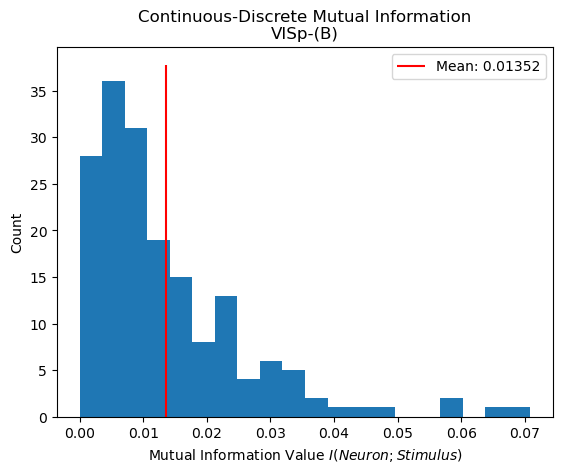

C:\Users\10690\AppData\Local\Temp\ipykernel_8464\353198015.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


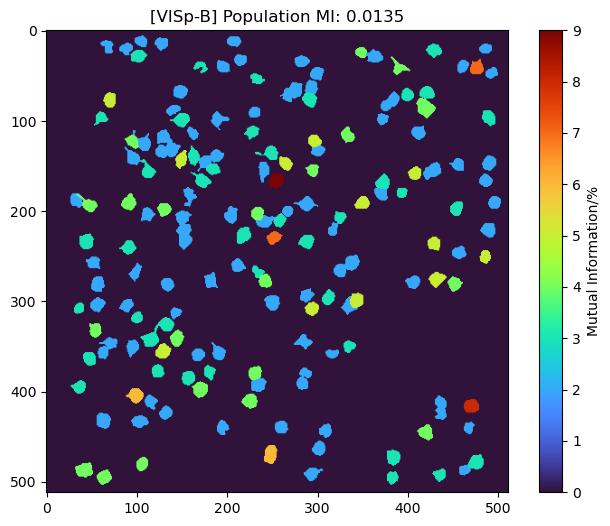

{'brain_region': 'VISp', 'session': 'B', 'population_mi': 0.013515526032909047}

In [33]:
Target_Brain_region = 'VISp'
data_root = 'data'
session_letter = 'B'

VISp_B_ts_sessions,  VISp_B_dff_sessions, VISp_B_all_roi_masks_sessions , VISp_B_cids_sessions, VISp_B_metadata_sessions, VISp_B_spike_info_sessions, VISp_B_information_dicts = create_session_data(Target_Brain_region = Target_Brain_region, data_root=data_root, session_letter=session_letter)
VISp_B_contained_names, VISp_B_contained_keys = get_contained_names(VISp_B_information_dicts)
VISp_B_total_stimulus = create_stimulus_mat(VISp_B_contained_names,ts=VISp_B_ts_sessions[0])
VISp_B_stimulus_vec = stimulus_mat2vec(VISp_B_total_stimulus)
VISp_B_selected_ts = np.where(VISp_B_stimulus_vec!=0)[0]
VISp_B_selected_vec = VISp_B_stimulus_vec[VISp_B_selected_ts]
VISp_B_selected_spikes = VISp_B_spike_info_sessions[0][:,VISp_B_selected_ts]
print('selected_spikes.shape',VISp_B_selected_spikes.shape)
# VISp_B_cdmis =continuous_discrete_MI(VISp_B_selected_spikes.T,VISp_B_selected_vec)# [continuous_discrete_MI(VISp_B_selected_spikes[_i,:],VISp_B_selected_vec) for _i in trange(VISp_B_selected_spikes.shape[0])]
# plt.hist(VISp_B_cdmis, bins=20)
# plt.title(f'Continuous-Discrete Mutual Information {Target_Brain_region}-(Session {session_letter})')
# plt.vlines(x=np.mean(VISp_B_cdmis),ymin=0,ymax=np.max(plt.gca().get_ylim()),color='red')
# plt.legend(['Mean: {:.2f}'.format(np.mean(VISp_B_cdmis))])
# plt.xlabel('Mutual Information Value $I(Neuron;Stimulus)$')
# plt.ylabel('Count')
# plt.show()

analyze_session(VISp_B_selected_spikes, VISp_B_selected_vec, VISp_B_all_roi_masks_sessions, Target_Brain_region, session_letter)

(5893, 6)
[VISp-B First 20] Population MI: 0.0068


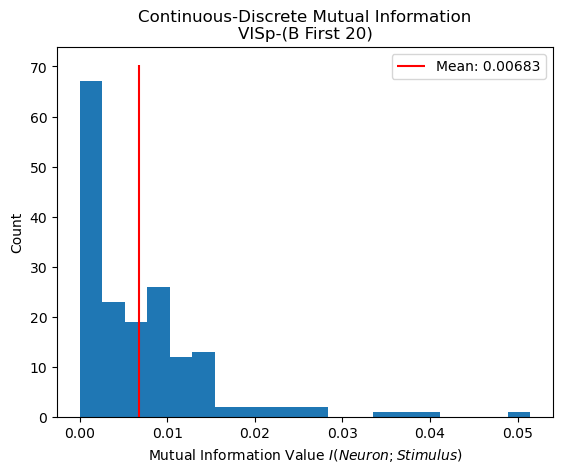

C:\Users\10690\AppData\Local\Temp\ipykernel_8464\353198015.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


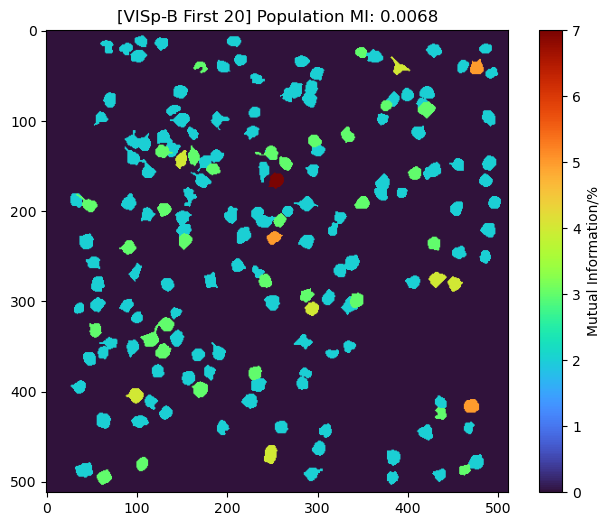

[VISp-B Second 20] Population MI: 0.0067


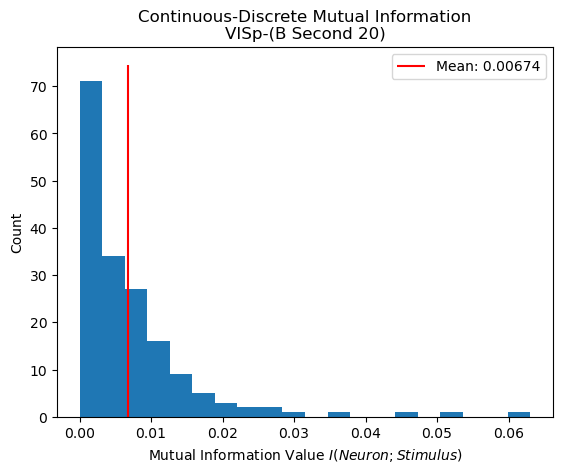

C:\Users\10690\AppData\Local\Temp\ipykernel_8464\353198015.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


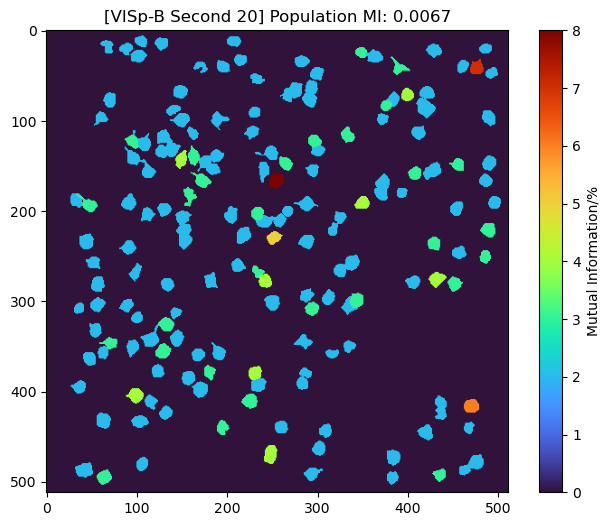

[VISp-B Third 20] Population MI: 0.0065


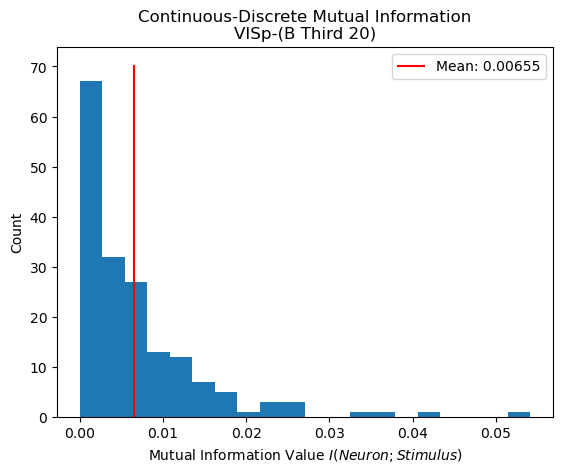

C:\Users\10690\AppData\Local\Temp\ipykernel_8464\353198015.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


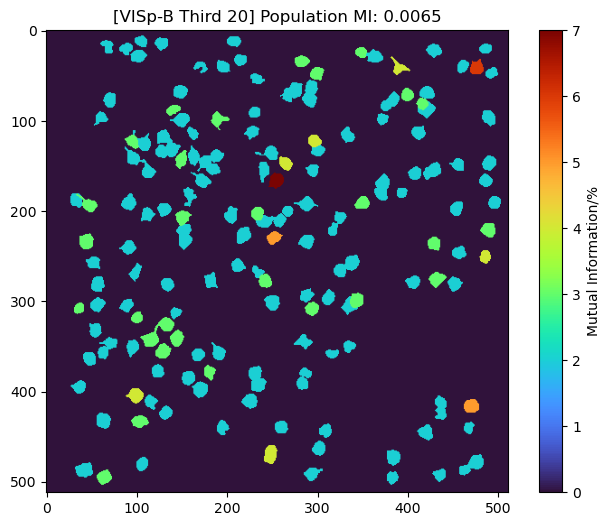

[VISp-B Forth 20] Population MI: 0.0090


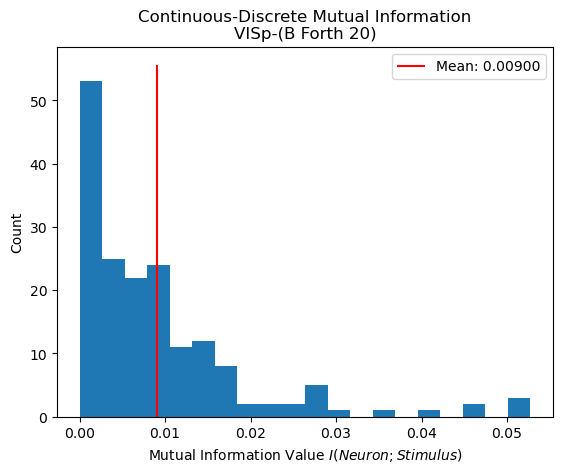

C:\Users\10690\AppData\Local\Temp\ipykernel_8464\353198015.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


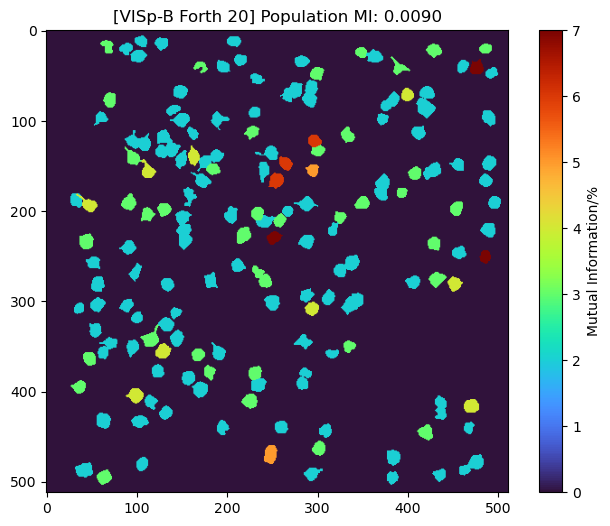

[VISp-B Fifth 20] Population MI: 0.0157


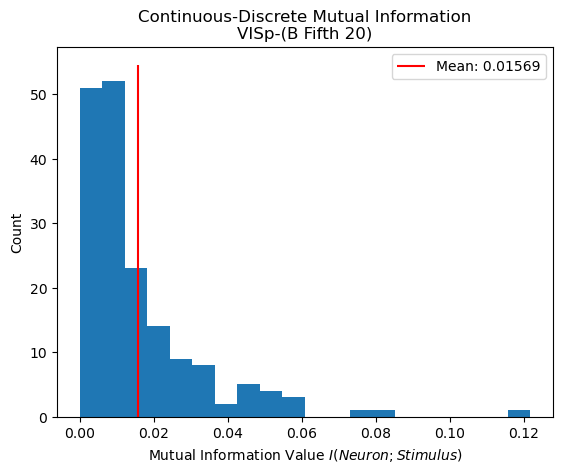

C:\Users\10690\AppData\Local\Temp\ipykernel_8464\353198015.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('turbo')#,len(np.unique([label,0])))


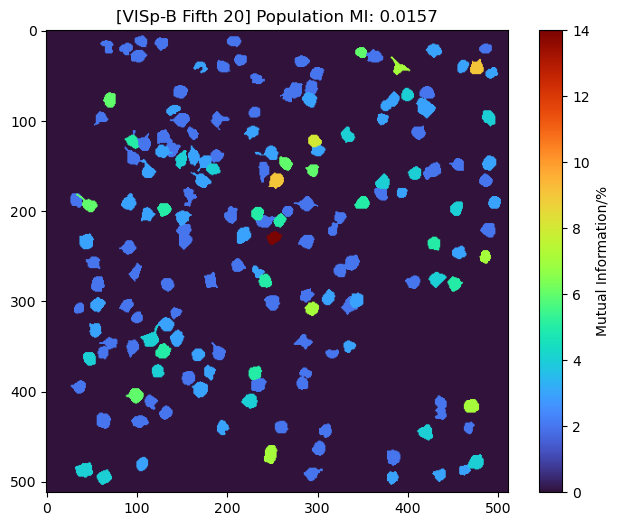

{'brain_region': 'VISp',
 'session': 'B Fifth 20',
 'population_mi': 0.015687836701768237}

In [34]:
indices = get_indices_of_segments_every_20_percent(VISp_B_selected_vec)
indices = indices.reshape(-1, 6)
print(indices.shape)
first_20_percent_indices = indices[:, 0:2]
second_20_percent_indices = indices[:, 1:3]
third_20_percent_indices = indices[:, 2:4]
forth_20_percent_indices = indices[:, 3:5]
fifth_20_percent_indices = indices[:, 4:6]
def generate_indices(percent_indices):
    ans = []
    for i in range(len(percent_indices)):
        ans = ans + np.arange(percent_indices[i,0], percent_indices[i,1]+1).tolist()
    ans = np.array(ans)
    return ans
first20_idx = generate_indices(first_20_percent_indices)
second20_idx = generate_indices(second_20_percent_indices)
third20_idx = generate_indices(third_20_percent_indices)
forth20_idx = generate_indices(forth_20_percent_indices)
fifth20_idx = generate_indices(fifth_20_percent_indices)

first20_stimulus = VISp_B_selected_spikes[:,first20_idx]
second20_stimulus = VISp_B_selected_spikes[:,second20_idx]
third20_stimulus = VISp_B_selected_spikes[:,third20_idx]
forth20_stimulus = VISp_B_selected_spikes[:,forth20_idx]
fifth20_stimulus = VISp_B_selected_spikes[:,fifth20_idx]
analyze_session(first20_stimulus, VISp_B_selected_vec[first20_idx], VISp_B_all_roi_masks_sessions, Target_Brain_region, session_letter+' First 20')
analyze_session(second20_stimulus, VISp_B_selected_vec[second20_idx], VISp_B_all_roi_masks_sessions, Target_Brain_region, session_letter+' Second 20')
analyze_session(third20_stimulus, VISp_B_selected_vec[third20_idx], VISp_B_all_roi_masks_sessions, Target_Brain_region, session_letter+' Third 20')
analyze_session(forth20_stimulus, VISp_B_selected_vec[forth20_idx], VISp_B_all_roi_masks_sessions, Target_Brain_region, session_letter+' Forth 20')
analyze_session(fifth20_stimulus, VISp_B_selected_vec[fifth20_idx], VISp_B_all_roi_masks_sessions, Target_Brain_region, session_letter+' Fifth 20')